## Load libraries

In [1]:
from dotenv import dotenv_values
import numpy as np
import warnings
import os
import pandas as pd 
import matplotlib.pyplot as plt 
from HurstIndexSolver.HurstIndexSolver  import HurstIndexSolver
from HurstIndexSolver.fgn  import fgn
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")


### Load data and initialize variables

In [2]:
start_date = "2005-01-01"
end_date = "2022-12-31"

In [3]:

config = dotenv_values("../config/.env")

In [4]:
ALPHA_API = config["ALPHA_API"]

In [5]:
if os.path.isfile("../data/raw/spy.csv"):
    spy = pd.read_csv("../data/raw/spy.csv", parse_dates=True, index_col=0)
else:
    spy = yf.download("SPY", start=start_date, end=end_date)
    spy.to_csv("../data/raw/spy.csv")

In [6]:
spy = spy[spy.index<"31-12-2017"]

### Compute Hurst according to Zhang

In [7]:
HSolver = HurstIndexSolver()

In [8]:
max_scale =100
HSolver.EstHurstLSSD(np.diff(spy["Close"].values), max_scale=max_scale)

0.467446570335479

### Multifractal simulation

In [9]:
from MMAR.MMAR import MMAR 

In [10]:
mmar = MMAR(spy["Close"])

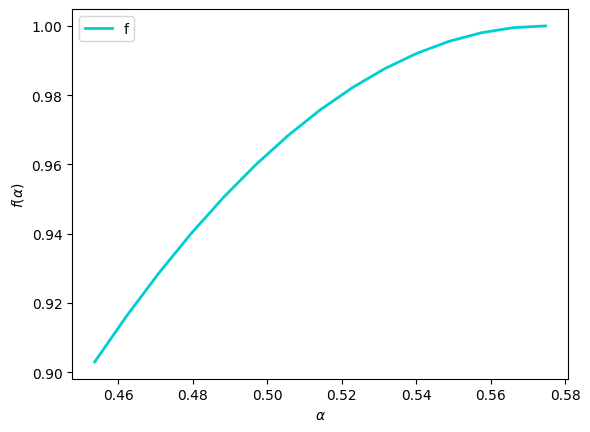

In [11]:
mmar.plot_alpha()

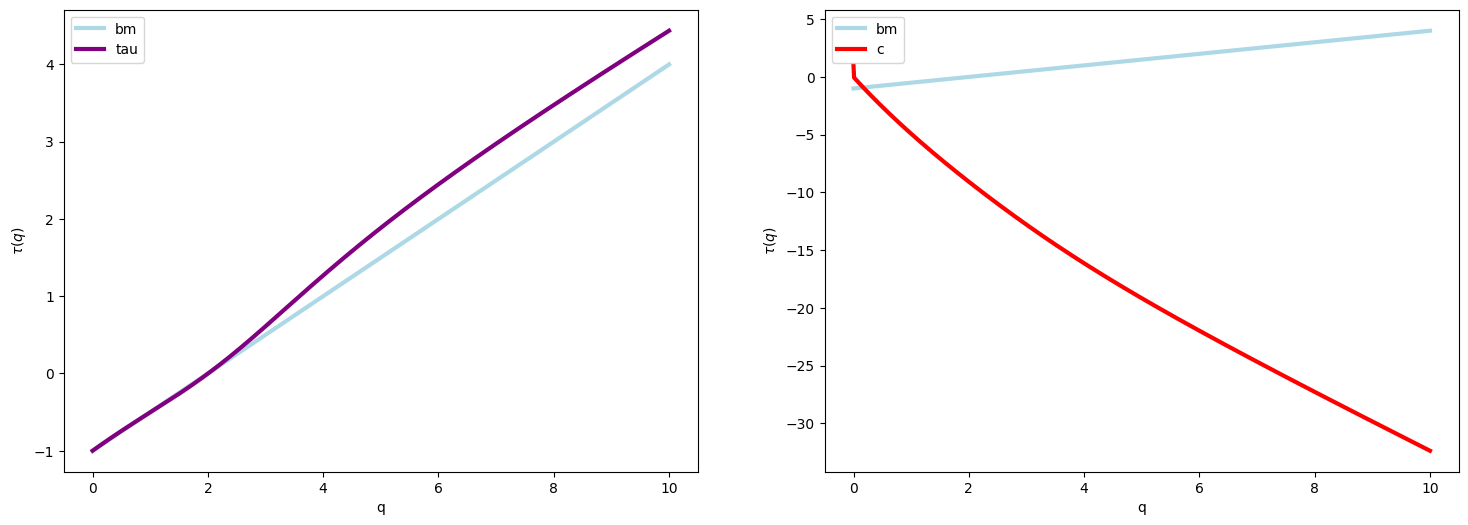

In [12]:
mmar.plot_scaling()

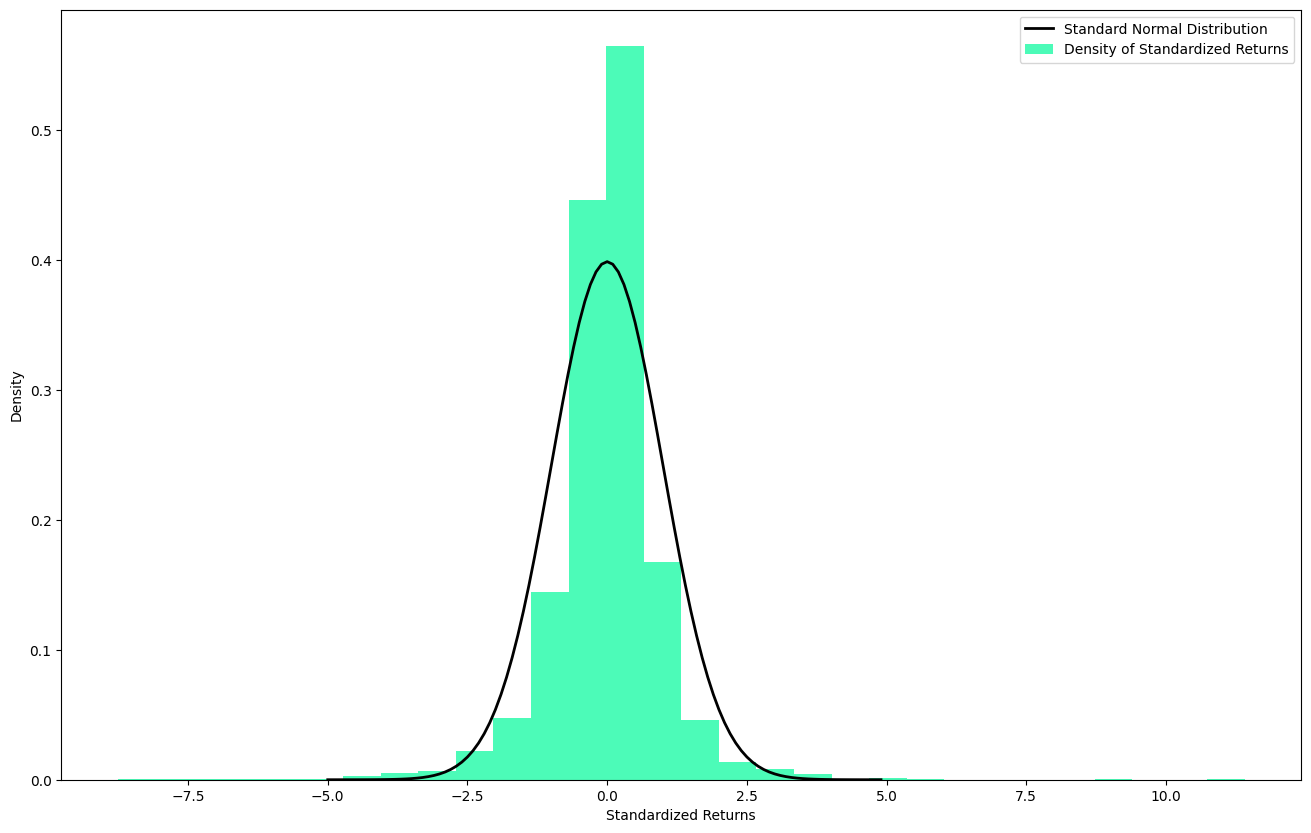

In [13]:
mmar.plot_density()

In [14]:
mmar.H

0.4991659905391841

In [15]:
S0 = spy.Close.iloc[-1]
simulation = mmar.get_MMAR_MC(S0, n=22, num_sim=1_000_000)

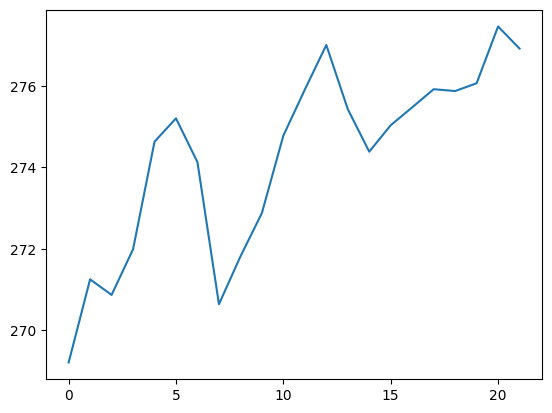

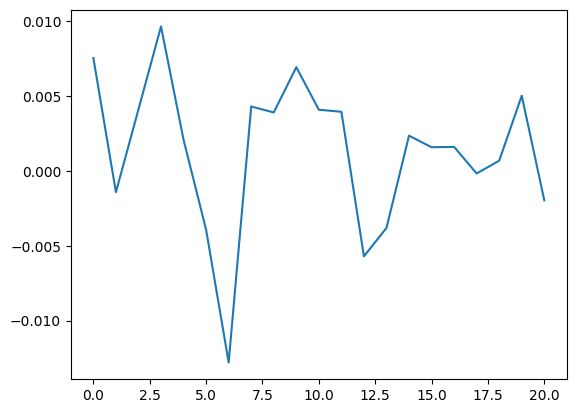

In [16]:
gmmar_sim = simulation[0,:]

plt.plot(gmmar_sim)
plt.show()

nmarr_sim = np.diff(np.log(gmmar_sim))
plt.plot(nmarr_sim)
plt.show()

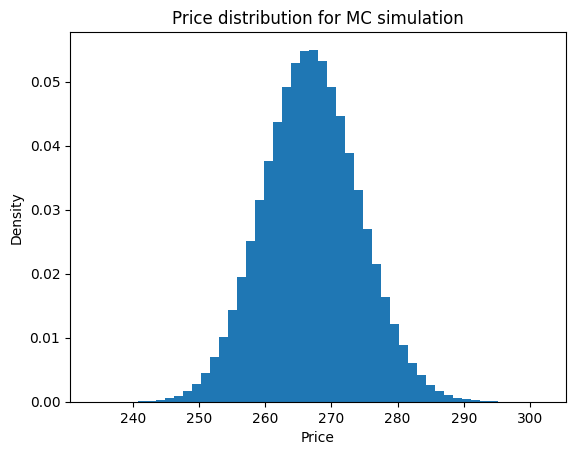

In [17]:
plt.hist(simulation[:,-1:], bins=50, density=True)
plt.xlabel("Price")
plt.ylabel("Density")
plt.title("Price distribution for MC simulation")
plt.show()

In [18]:
def get_call_price(prices, strike, r, T):
    values = prices[prices>strike]
    prob = len(values)/len(prices)
    exp_val = np.mean(values)
    print(f"Probability expected price {exp_val:.2f} > {strike:.2f} is {prob:.2%}")
    return np.exp(-r*T)*prob*(exp_val-strike)

In [19]:
get_call_price(simulation[:,-1:], 269, 3/100, 22/360)

Probability expected price 274.19 > 269.00 is 38.41%


1.9894266008786092

In [20]:
S0

266.8599853515625

### Option chain

In [21]:
opt_chain = pd.read_csv("../data/processed/chain2018.csv.gz",  parse_dates=True)

In [22]:
opt_chain.columns

Index(['QUOTE_DATE', 'UNDERLYING_LAST', 'EXPIRE_DATE', 'DTE', 'C_DELTA',
       'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_IV', 'C_VOLUME', 'C_LAST',
       'C_SIZE', 'C_BID', 'C_ASK', 'STRIKE', 'P_BID', 'P_ASK', 'P_SIZE',
       'P_LAST', 'P_DELTA', 'P_GAMMA', 'P_VEGA', 'P_THETA', 'P_RHO', 'P_IV',
       'P_VOLUME', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT'],
      dtype='object')

In [23]:
opt_chain.query('(EXPIRE_DATE=="2018-02-02")&(QUOTE_DATE=="2018-01-02")')[["UNDERLYING_LAST","STRIKE",  'C_LAST',
       'C_BID', 'C_ASK', 'C_IV', 'C_SIZE', 'C_VOLUME',]]

,UNDERLYING_LAST,STRIKE,C_LAST,C_BID,C_ASK,C_IV,C_SIZE,C_VOLUME
511,268.81,232.5,0.00,36.58,36.77,0.31245,30 x 28,NaN
512,268.81,235.0,0.00,34.09,34.29,0.29239,30 x 10,NaN
513,268.81,237.5,31.04,31.60,31.81,0.27423,20 x 10,2.0
514,268.81,240.0,28.10,29.13,29.33,0.25597,20 x 19,0.0
515,268.81,242.5,0.00,26.66,26.86,0.23967,20 x 29,NaN
516,268.81,245.0,0.00,24.20,24.40,0.22240,20 x 19,NaN
517,268.81,247.5,0.00,21.73,21.93,0.20563,20 x 29,NaN
518,268.81,250.0,0.00,19.29,19.48,0.19093,19 x 20,NaN
519,268.81,252.5,0.00,16.66,17.27,0.17623,253 x 253,NaN
520,268.81,255.0,13.78,14.41,14.60,0.15771,19 x 20,1.0


### Example strategy

In [24]:
quote_dates=[
 '2018-01-02',
 '2018-02-02',
 '2018-03-02',
 '2018-04-02',
 '2018-05-02',
 '2018-06-01',
 '2018-07-02',
 '2018-08-01',
 '2018-09-04',
 '2018-10-03',
 '2018-11-02',
 '2018-12-03']

In [25]:
exp_dates = [
 '2018-02-02',
 '2018-03-02',
 '2018-04-02',
 '2018-05-02',
 '2018-06-01',
 '2018-07-02',
 '2018-08-01',
 '2018-09-04',
 '2018-10-03',
 '2018-11-02',
 '2018-12-03',
 ]

Define a simple strategy. If the expected call price given our simulation is bigger than the market price, buy, otherwise sell.

In [26]:
def compute_strategy(chain, mmar,dates, n:int=22, num_sim:int=10_000, r:float=0.01):
    result = {}
    for i, date in enumerate(dates):
        quote_date = date[0]
        expire_date = date[1]
        df = chain.query('(EXPIRE_DATE==@expire_date)&(QUOTE_DATE==@quote_date)')[[ "UNDERLYING_LAST", "STRIKE", 'C_LAST','C_BID', 'C_ASK', 'C_IV', 'C_SIZE', 'C_VOLUME']]
        current_price = df.iloc[0,0]
        strike = np.ceil(current_price)
        s = 0.0
        while len(df[df.STRIKE == strike]["C_LAST"])==0:
            s+=1.0
            strike = np.ceil(current_price+s)
        call = df[df.STRIKE == strike]["C_LAST"].iloc[0]
        simulation = mmar.get_MMAR_MC(current_price, n=n, num_sim=num_sim)
        exp_call = np.round(get_call_price(simulation[:,-1:], strike, r, n/360),2)
        result[i]={"Buy_or_Sell": exp_call > call, "call":call, "exp_call":exp_call, "strike":strike, "price":current_price}
    return result

In [27]:
backtest = compute_strategy(opt_chain, mmar, zip(quote_dates, exp_dates), 22, 1_000_000, 1/100)

Probability expected price 274.84 > 269.00 is 48.99%
Probability expected price 281.89 > 276.00 is 47.48%
Probability expected price 275.63 > 270.00 is 45.09%
Probability expected price 264.89 > 260.00 is 36.37%
Probability expected price 269.51 > 264.00 is 45.44%
Probability expected price 279.89 > 274.00 is 47.95%
Probability expected price 278.00 > 272.00 is 50.03%
Probability expected price 287.15 > 281.00 is 49.52%
Probability expected price 296.33 > 290.00 is 49.31%
Probability expected price 298.33 > 292.00 is 48.68%
Probability expected price 277.90 > 272.00 is 48.74%


In [28]:
backtest = pd.DataFrame.from_dict(backtest, orient="index")
backtest["exp_price"] = backtest.price.shift(-1)
backtest

,Buy_or_Sell,call,exp_call,strike,price,exp_price
0,True,2.14,2.86,269.0,268.81,275.52
1,False,4.35,2.80,276.0,275.52,269.10
2,False,3.80,2.54,270.0,269.10,257.54
3,False,4.83,1.78,260.0,257.54,263.18
4,False,3.80,2.50,264.0,263.18,273.63
5,True,2.49,2.82,274.0,273.63,272.00
6,False,3.88,3.00,272.0,272.00,280.91
7,False,3.43,3.04,281.0,280.91,289.86
8,True,2.75,3.12,290.0,289.86,291.72
9,False,3.15,3.08,292.0,291.72,271.77


In [29]:
# In this short simualtion I used only 2018 data and excluded the last row since the exp_price is NaN.
profit = 0.0
for row in backtest.iloc[:-1,:].itertuples():  
    if row.Buy_or_Sell:
        profit += (row.exp_price-row.strike-row.call)
    else:
        profit += (max(row.strike-row.exp_price,0)+row.call)
print(f"Profit, without commissions and bid-ask spread, on {len(backtest)-1} tradings is $ {profit:.2f}")


Profit, without commissions and bid-ask spread, on 10 tradings is $ 65.69


The strategy seems to work fine in this short test. Let's add more data (2019 and 2020) and see how it performs. There seems to be an issue, though, with the simulation. At each run the values are extremely different while, with one million samples, they should converge. We may try with a bigger sample size.